In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
parent = os.path.dirname(os.getcwd())
parent = os.path.dirname(parent)

print(f"{parent = }")


import sys
if not parent in sys.path:
    sys.path.append(parent)

parent = '/lustre06/project/6067616/soroush1/WM_age_of_ultron'


In [3]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
import matplotlib.pyplot as plt

import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import zipfile
import os
import random

In [ ]:
def unzip_file(zip_path, extract_path=None):
    # If no extract path is provided, use the current directory
    if extract_path is None:
        extract_path = os.getcwd()
    
    # Create the extract directory if it doesn't exist
    os.makedirs(extract_path, exist_ok=True)
    
    # Open the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extract all contents to the specified directory
        zip_ref.extractall(extract_path)
    
    print(f"Successfully extracted {zip_path} to {extract_path}")

# Example usage
zip_file_path = "data/coco1600/images_cocogray.zip"
extraction_path = "data/coco1600/"  # Optional

unzip_file(zip_file_path, extraction_path)

In [5]:
df = pd.read_csv("data/coco1600/coco1600_meta.csv")
print(f"{df['obj'].value_counts()}")
df.head()

obj
bear                       160
ELEPHANT_M                 160
face0001                   160
alfa155                    160
breed_pug                  160
Apple_Fruit_obj            160
_001                       160
f16                        160
lo_poly_animal_CHICKDEE    160
zebra                      160
Name: count, dtype: int64


,filename,image_id,image_names,obj,urls
0,COCO_val2014_000000011364.jpg,11364.0,im0.png,bear,https://s3.amazonaws.com/ms-coco-images/COCO_v...
1,COCO_val2014_000000015528.jpg,15528.0,im1.png,bear,https://s3.amazonaws.com/ms-coco-images/COCO_v...
2,COCO_val2014_000000020247.jpg,20247.0,im2.png,bear,https://s3.amazonaws.com/ms-coco-images/COCO_v...
3,COCO_val2014_000000027272.jpg,27272.0,im3.png,bear,https://s3.amazonaws.com/ms-coco-images/COCO_v...
4,COCO_val2014_000000034193.jpg,34193.0,im4.png,bear,https://s3.amazonaws.com/ms-coco-images/COCO_v...


In [6]:
def add_image_paths_to_df(df, image_folder):
    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    # Create a dictionary mapping image names to their full paths
    # image_paths = {f: os.path.join(image_folder, f) for f in image_files}
    image_paths = {f: os.path.join(image_folder, f) for f in image_files}
    
    
    # Function to get the path for each image name
    def get_image_path(image_name):
        return image_paths.get(image_name, '')
    
    # Add the new column with image paths
    df['src_pth'] = df['image_names'].apply(get_image_path)
    
    return df

# Example usage
image_folder = 'data/coco1600/images_cocogray/'

# Add image paths to the DataFrame
df_with_paths = add_image_paths_to_df(df, image_folder)

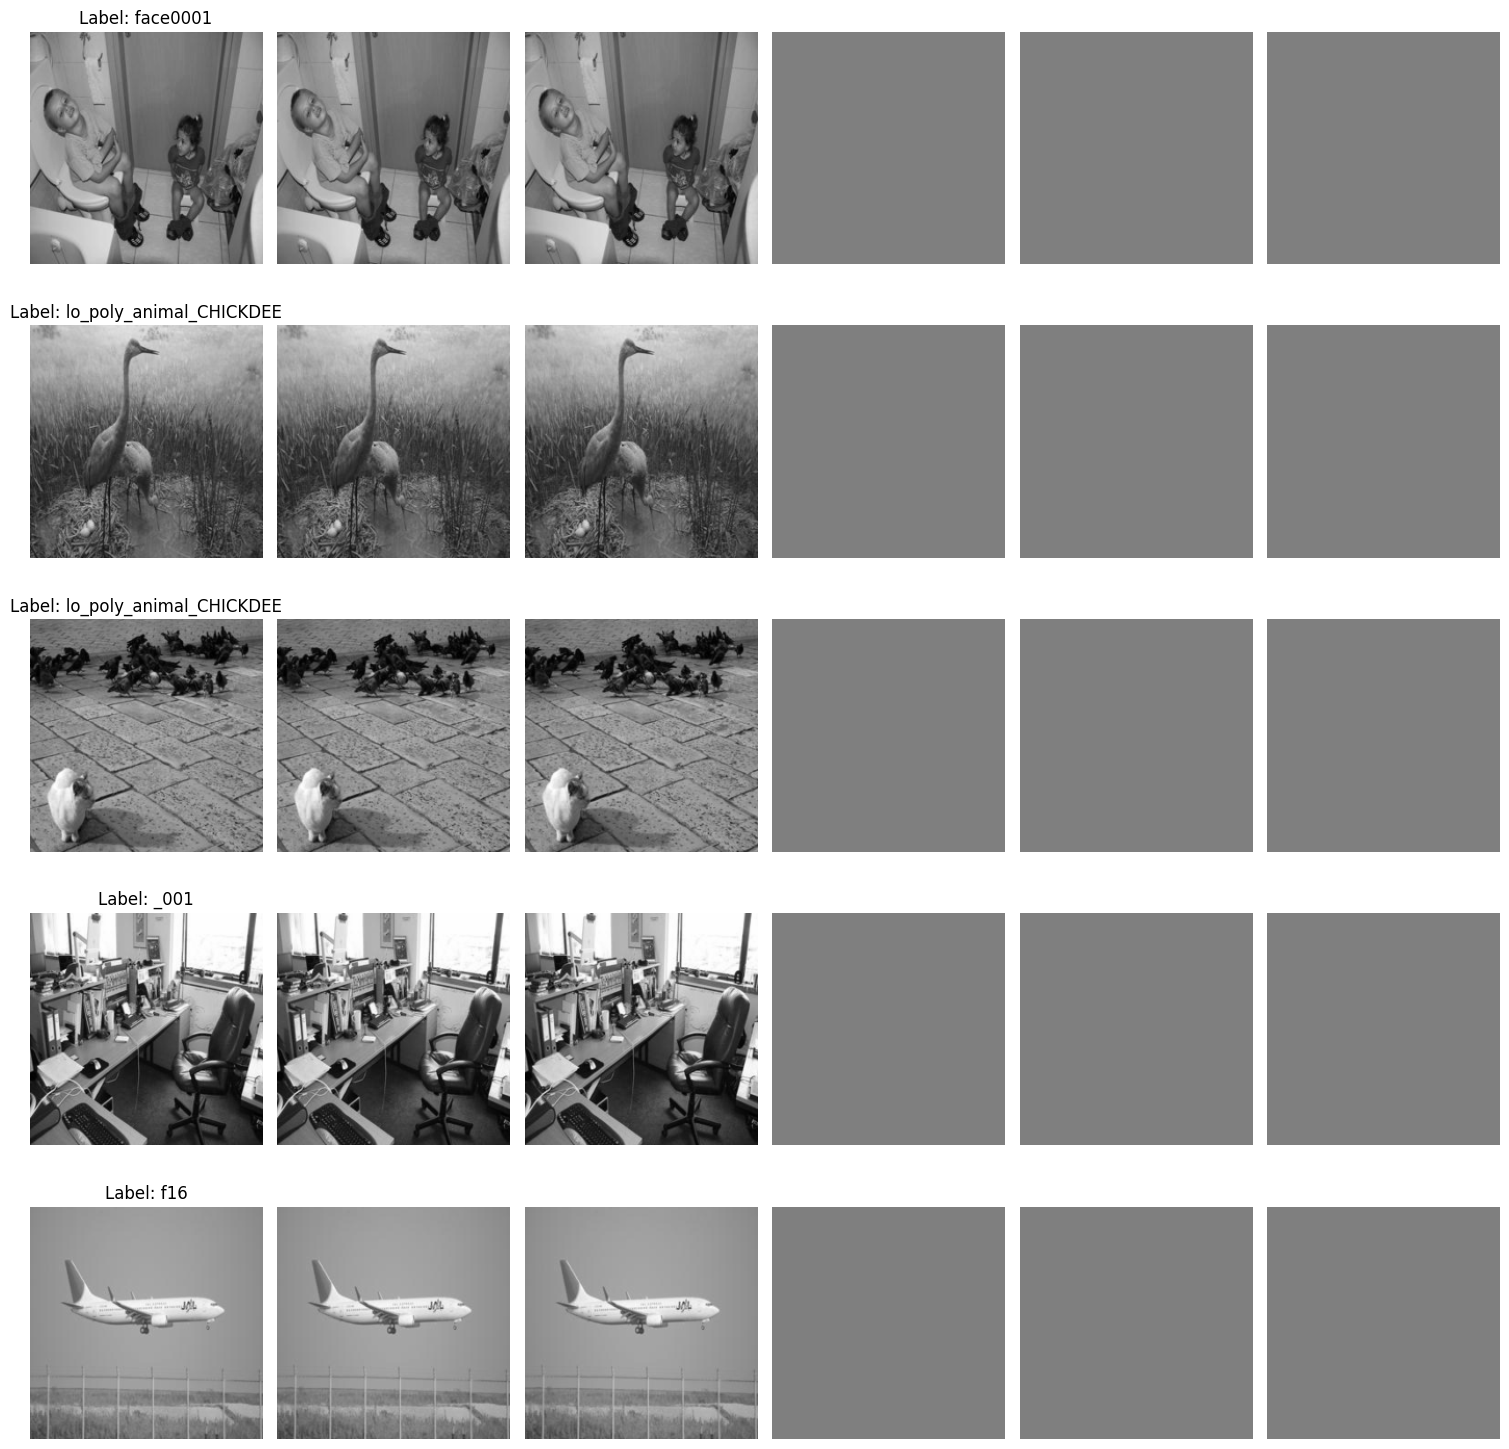

In [12]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

class CustomImageSequenceDataset(Dataset):
    def __init__(self, meta_file, img_dir, num_timesteps=5, transform=None):
        self.img_labels = pd.read_csv(meta_file)
        self.img_dir = img_dir
        self.num_timesteps = num_timesteps
        self.transform = transform
        self.to_grayscale = transforms.Grayscale(3)  # 3-channel grayscale
        
        # Create index map for object labels
        self.label_to_idx = {label: idx for idx, label in enumerate(self.img_labels['obj'].unique())}
    
    def __len__(self):
        return len(self.img_labels)

    def __coco1600_to_hvm200(self, label):

        coco1600_to_hvm200 = {
            "bear": "bear",
            "ELEPHANT_M": "elephant",
            "face0001": "person",
            "alfa155": "car",
            "breed_pug": "dog",
            "Apple_Fruit_obj": "apple",
            "_001": "chair",
            "f16": "plane",
            "lo_poly_animal_CHICKDEE": "bird",
            "zebra": "zebra"
        }
        
        return coco1600_to_hvm200[label]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.img_labels.iloc[idx]['image_names']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        label = self.img_labels.iloc[idx]['obj']
        label_idx = self.label_to_idx[label]
        
        # Create sequence: first frame is the original image, rest are grayscale
        sequence = [self.transform(image) if self.transform else transforms.ToTensor()(image) for _ in range(3)] # add 100ms of images
        for _ in range(self.num_timesteps - 1):
            # gray_value = torch.rand(1).item()
            gray_value = 0.5
            
            gray_frame = torch.full((3, 224, 224), gray_value)  # Assuming 224x224 is your image size
            sequence.append(gray_frame)
        
        sequence = torch.stack(sequence)
        return sequence, label_idx

def plot_sequence_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, dataset.num_timesteps + 3 - 1, figsize=(15, 3*num_samples))
    
    for i in range(num_samples):
        sequence, label = dataset[np.random.randint(len(dataset))]
        for t in range(dataset.num_timesteps + 3 - 1):
            ax = axes[i, t]
            ax.imshow(sequence[t].permute(1, 2, 0))
            ax.axis('off')
            if t == 0:
                ax.set_title(f"Label: {list(dataset.label_to_idx.keys())[list(dataset.label_to_idx.values()).index(label)]}")
    
    plt.tight_layout()
    plt.show()

# Example usage:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(3),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])

# Create the dataset
dataset = CustomImageSequenceDataset(meta_file='data/coco1600/coco1600_meta.csv',
                             img_dir='data/coco1600/images_cocogray',
                                     num_timesteps=4,
                             transform=transform)

# Plot some samples
plot_sequence_samples(dataset)

# # You can now use this dataset with PyTorch DataLoader
# from torch.utils.data import DataLoader

# dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# # Example of iterating through the dataset
# for images, labels in dataloader:
#     print(f"Batch shape: {images.shape}")
#     print(f"Labels shape: {labels.shape}")
#     break  # Just print the first batch and break

In [22]:
dataset.label_to_idx

{'bear': 0,
 'ELEPHANT_M': 1,
 'face0001': 2,
 'alfa155': 3,
 'breed_pug': 4,
 'Apple_Fruit_obj': 5,
 '_001': 6,
 'f16': 7,
 'lo_poly_animal_CHICKDEE': 8,
 'zebra': 9}

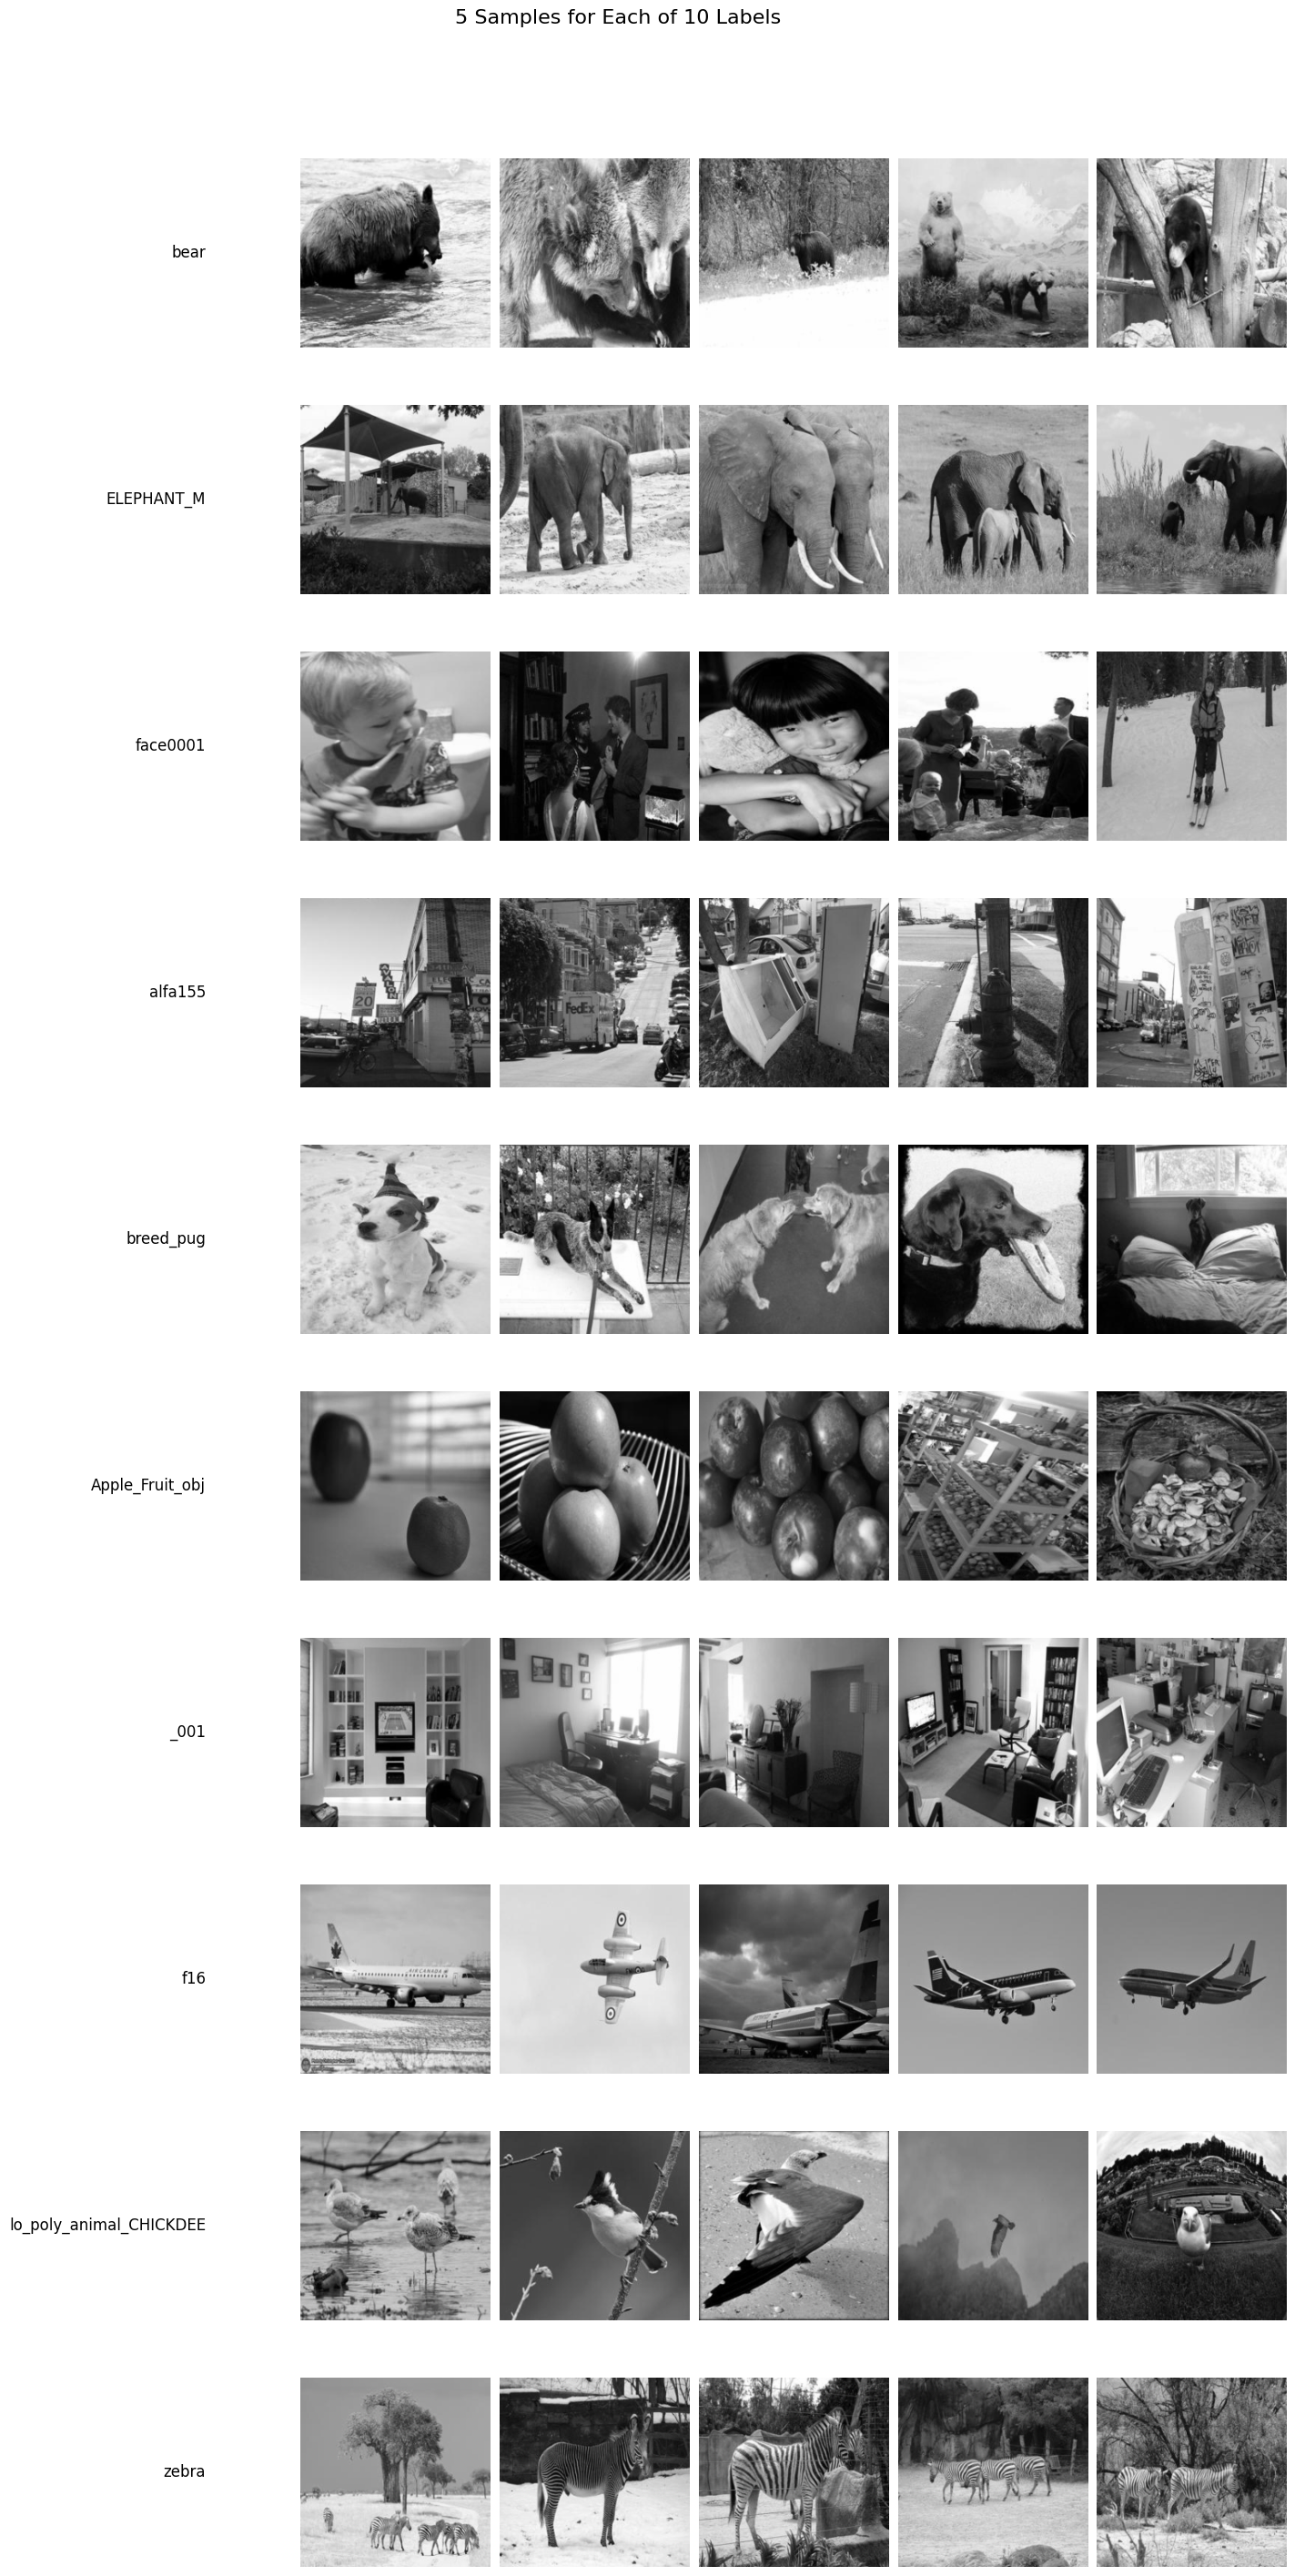

In [14]:
def plot_samples_by_label(dataset, num_labels=10, samples_per_label=5):
    # Get all unique labels
    all_labels = list(dataset.label_to_idx.keys())
    
    # Randomly select 10 labels if there are more than 10
    if len(all_labels) > num_labels:
        selected_labels = random.sample(all_labels, num_labels)
    else:
        selected_labels = all_labels

    # Create a figure
    fig, axes = plt.subplots(num_labels, samples_per_label, figsize=(15, 3*num_labels))
    fig.suptitle("5 Samples for Each of 10 Labels", fontsize=16)

    for label_idx, label in enumerate(selected_labels):
        # Find all indices for this label
        label_indices = [i for i, row in dataset.img_labels.iterrows() if row['obj'] == label]
        
        # Randomly select 5 samples
        selected_indices = random.sample(label_indices, min(samples_per_label, len(label_indices)))
        
        for sample_idx, data_idx in enumerate(selected_indices):
            sequence, _ = dataset[data_idx]
            
            # Plot only the first image of the sequence (original image)
            ax = axes[label_idx, sample_idx]
            ax.imshow(sequence[0].permute(1, 2, 0))
            ax.axis('off')
            
            if sample_idx == 0:
                # Add label name to the left of the row
                ax.set_ylabel(label, rotation=0, labelpad=40, va='center', fontsize=10)
        
        # Add label name as a title for the row
        axes[label_idx, 0].text(-0.5, 0.5, label, transform=axes[label_idx, 0].transAxes, 
                                fontsize=12, va='center', ha='right', rotation=0)

    plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])
    plt.show()

# Plot samples by label
plot_samples_by_label(dataset)

In [16]:
coco1600_to_hvm200 = {
    "bear": "bear",
    "ELEPHANT_M": "elephant",
    "face0001": "person",
    "alfa155": "car",
    "breed_pug": "dog",
    "Apple_Fruit_obj": "apple",
    "_001": "chair",
    "f16": "plane",
    "lo_poly_animal_CHICKDEE": "bird",
    "zebra": "zebra"
}

In [15]:
df = pd.read_csv("data/coco1600/coco1600_meta.csv")
print(f"{df['obj'].value_counts()}")
df.head()

obj
bear                       160
ELEPHANT_M                 160
face0001                   160
alfa155                    160
breed_pug                  160
Apple_Fruit_obj            160
_001                       160
f16                        160
lo_poly_animal_CHICKDEE    160
zebra                      160
Name: count, dtype: int64


,filename,image_id,image_names,obj,urls
0,COCO_val2014_000000011364.jpg,11364.0,im0.png,bear,https://s3.amazonaws.com/ms-coco-images/COCO_v...
1,COCO_val2014_000000015528.jpg,15528.0,im1.png,bear,https://s3.amazonaws.com/ms-coco-images/COCO_v...
2,COCO_val2014_000000020247.jpg,20247.0,im2.png,bear,https://s3.amazonaws.com/ms-coco-images/COCO_v...
3,COCO_val2014_000000027272.jpg,27272.0,im3.png,bear,https://s3.amazonaws.com/ms-coco-images/COCO_v...
4,COCO_val2014_000000034193.jpg,34193.0,im4.png,bear,https://s3.amazonaws.com/ms-coco-images/COCO_v...
